In [155]:
#Import modules
from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [156]:
dataset_path = Path().resolve()/"HomeC.csv"
df = pd.read_csv(dataset_path)

In [157]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [158]:
data_per_hour = df.resample("H").mean()
day= data_per_hour.resample("D").sum()
day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,...,686.382667,24349.714333,179.372000,13.740000,6372.833333,0.002127,564.057333,0.038667,9.901133,0.300536
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,...,597.671000,24342.397667,188.510667,6.389000,6080.966667,0.000000,442.727000,0.000000,10.860203,0.264237
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,...,632.028667,24218.851000,181.573000,3.405000,5686.466667,0.000000,528.218333,0.000000,10.220414,0.315454
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,...,105.605333,24490.989667,295.261333,3.132667,7484.800000,0.000000,106.235000,0.000000,11.703699,0.286346
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,...,143.858000,24847.155000,116.545333,0.052000,7033.766667,0.000000,-14.553667,0.000000,13.359033,0.142002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,...,466.010000,24920.738333,128.644500,2.005667,1959.100000,0.002007,345.026167,0.079333,11.926358,0.185857
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,...,971.430000,24270.318167,263.211167,13.821333,5838.650000,0.023833,897.677667,0.775667,8.903855,0.199664
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,...,659.025833,24400.061833,207.932000,7.932500,7057.916667,0.000000,535.855000,0.000000,8.326470,0.093495
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,...,640.318000,24215.804167,97.669667,10.013000,4163.450000,0.236265,622.643833,5.310500,9.010939,0.095405


# Decomposition to look into data

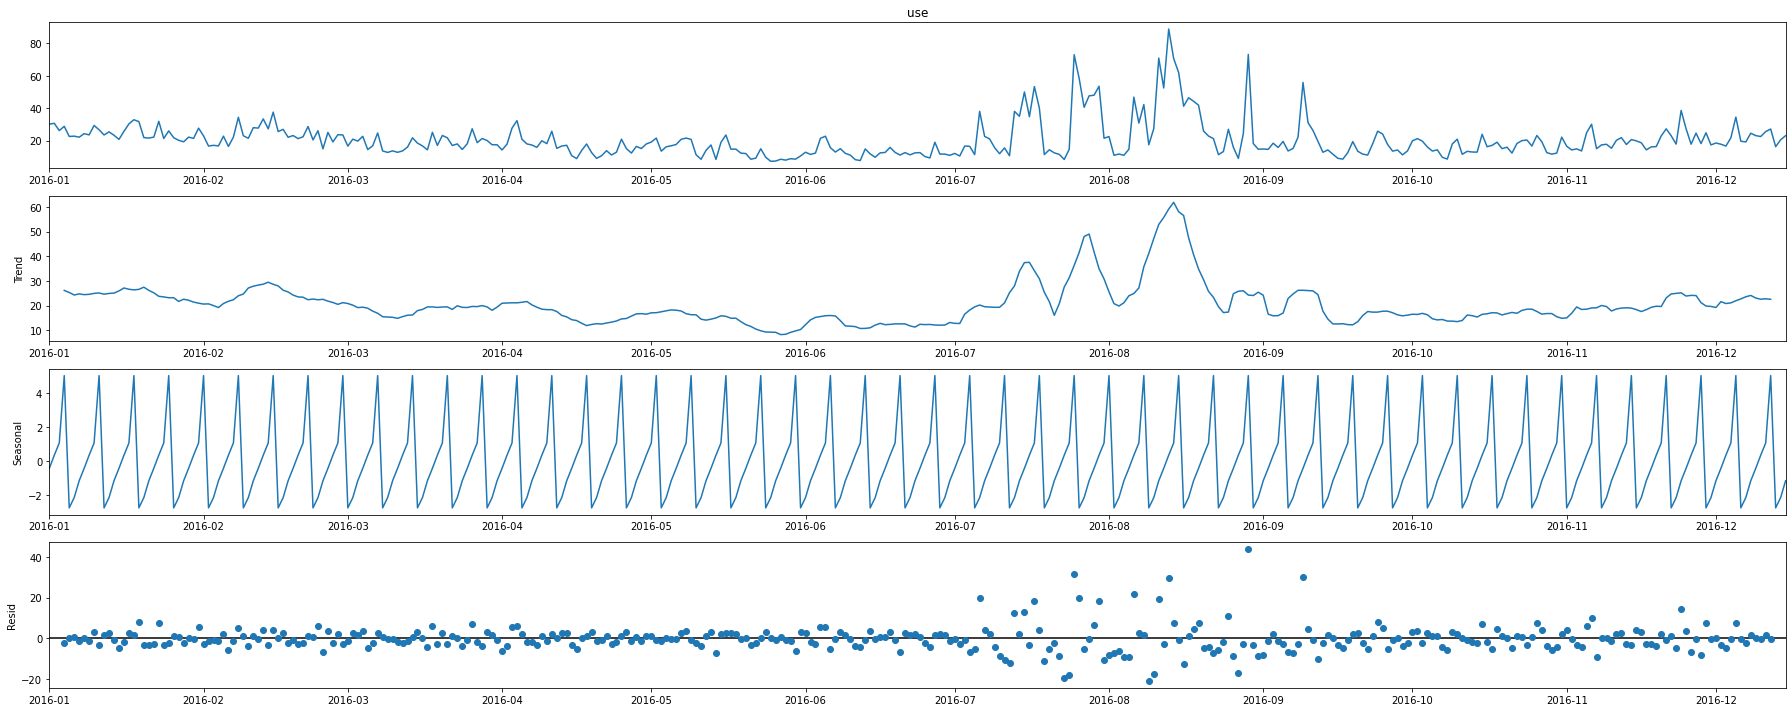

In [160]:
# perform decomposition
result = seasonal_decompose(day.use, model='additive')
result.plot()
plt.show()

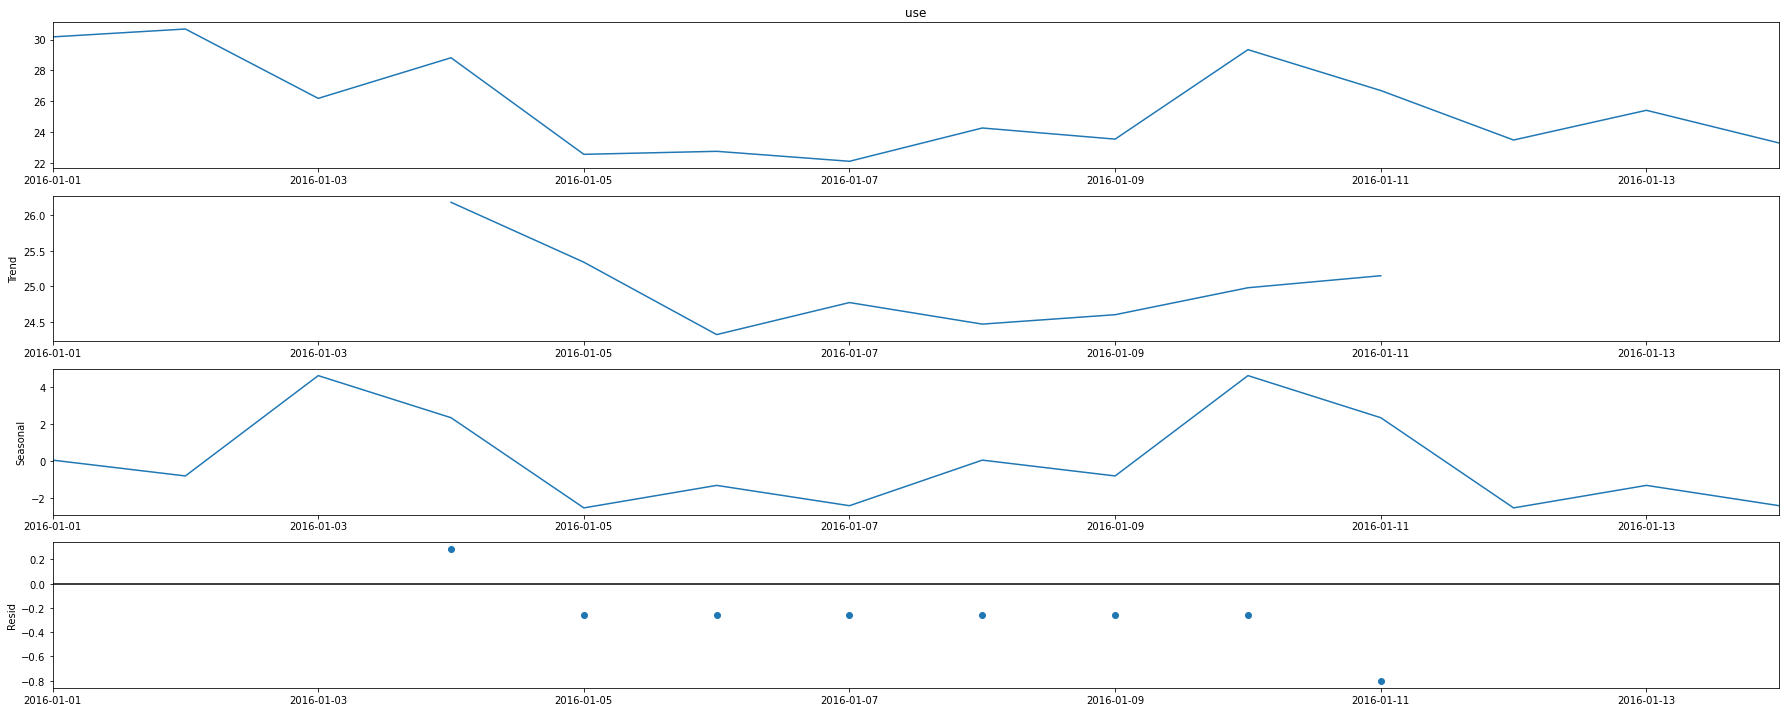

In [183]:
# the sensonal is too small to look at, reduce the time frame to have a closer look
result = seasonal_decompose(day.use[:14], model='additive')
result.plot()
plt.show()
# from the seasonal part, we can see the data has seasonality of 7 days, 
# and the amplitude of seasonality does not change so it is additive

# Arima model

In [184]:
day_use= pd.Series(day.use.values, index = day.index)
day_use

2016-01-01    30.169358
2016-01-02    30.680708
2016-01-03    26.187171
2016-01-04    28.818997
2016-01-05    22.561987
                ...    
2016-12-11    25.590984
2016-12-12    27.150711
2016-12-13    16.241008
2016-12-14    20.486863
2016-12-15    23.036400
Freq: D, Length: 350, dtype: float64

In [215]:
# split data
use_split_ratio = round(day_use.shape[0]*0.8)
train_use = day_use.iloc[:use_split_ratio]
test_use = day_use.iloc[use_split_ratio:]
test_use.isnull().values.any()

False

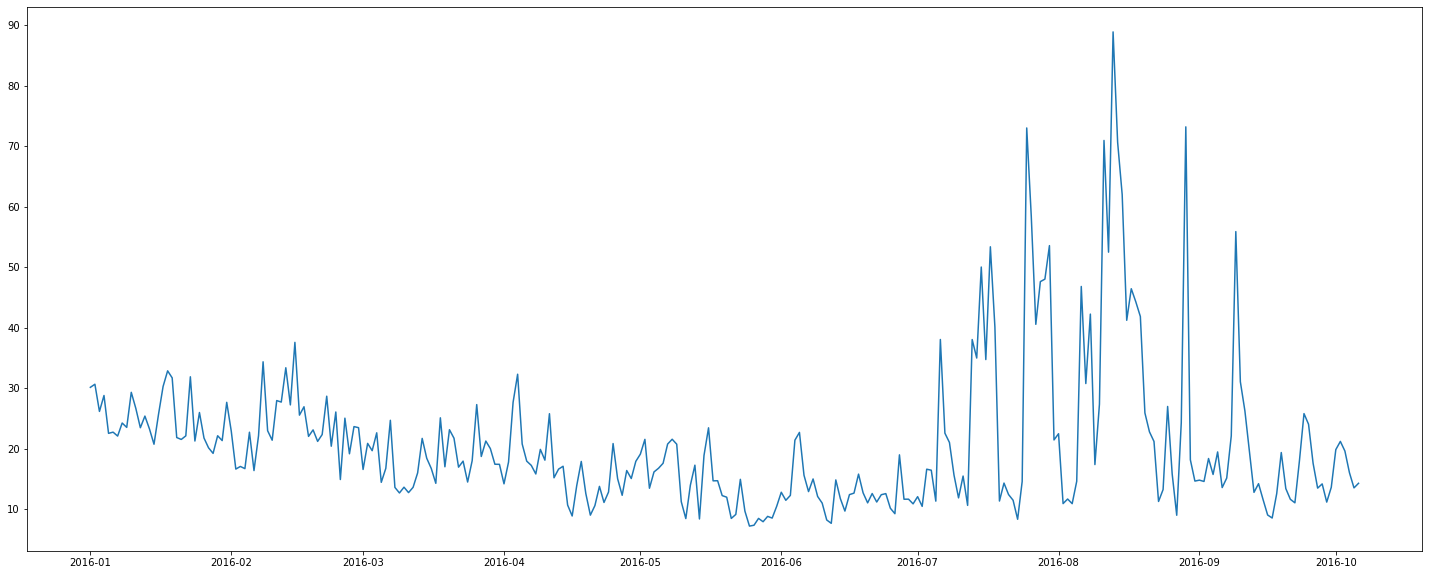

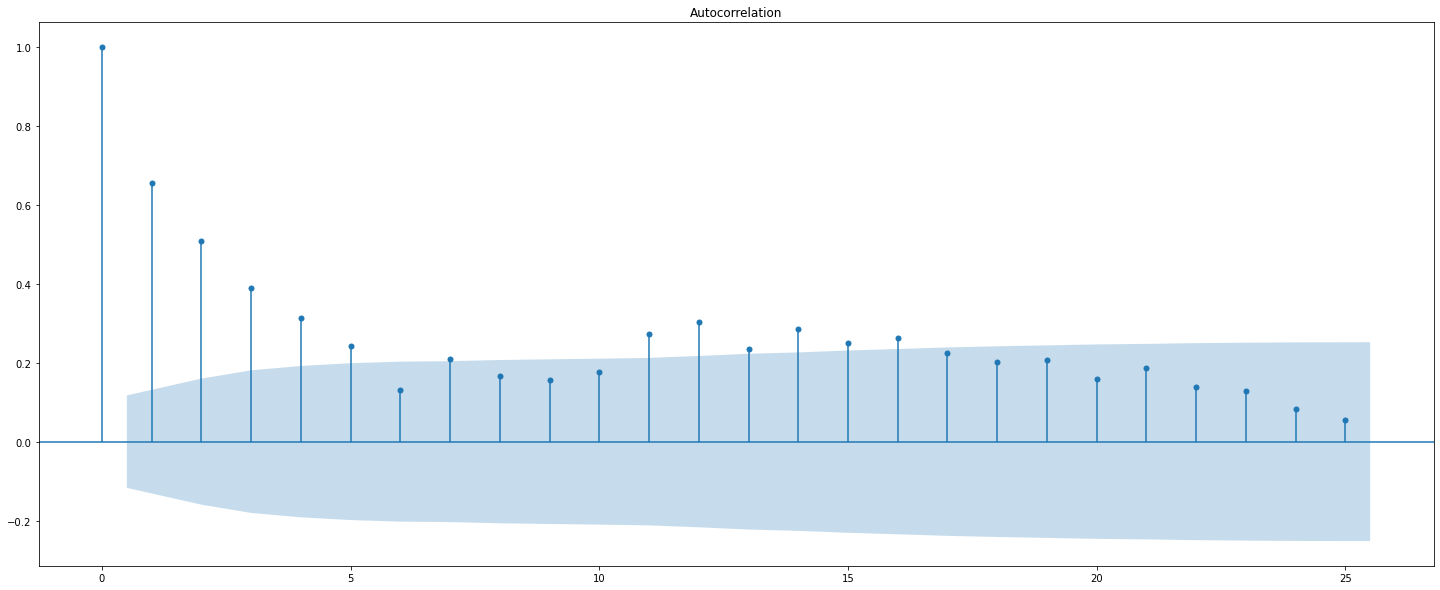

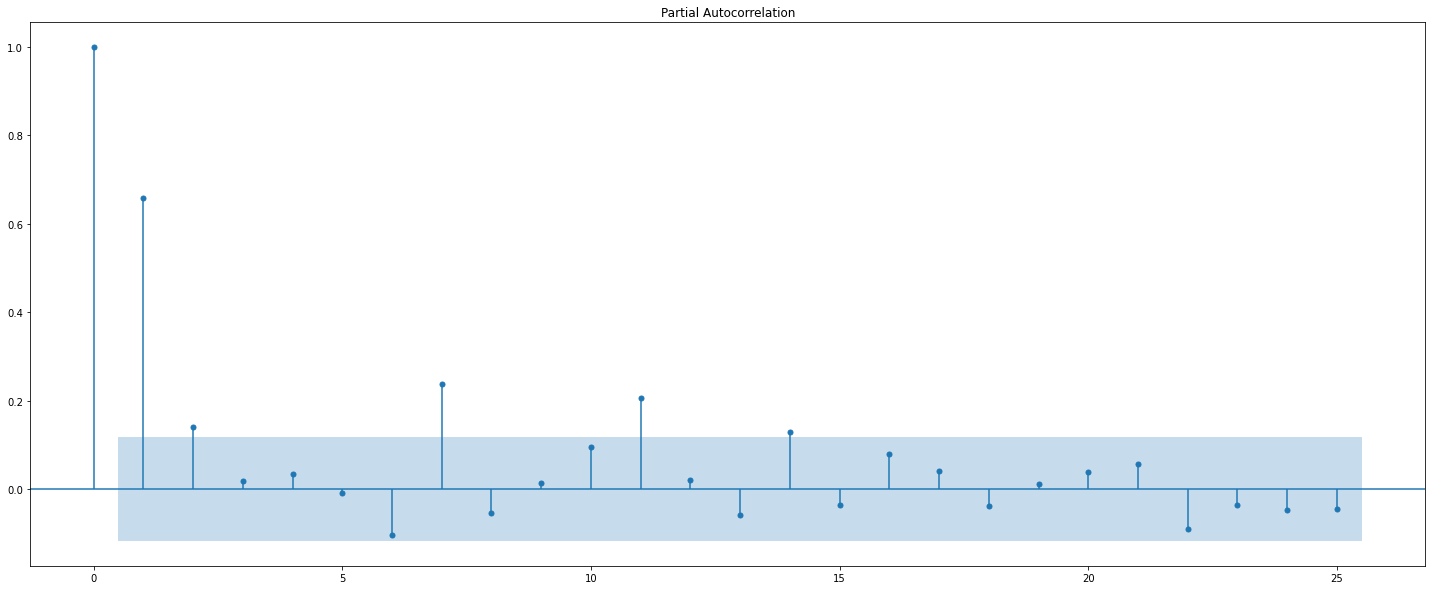

In [216]:
# plot acf and pacf
plt.rc('figure',figsize=(25,10))
plt.plot(train_use)
plot_acf(train_use);
plot_pacf(train_use);

We can see the acf plot is exponentially decay, so the data is probably not stationary and need to do differencing. We double check with the Augmented Dickey–Fuller test.

In [217]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
result_use = adfuller(train_use)
print_adf_result(result_use)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.644771
P-Value                   0.084092
# Lags Used              10.000000
# Observations Used     269.000000
Critical Value (1%)      -3.454896
Critical Value (5%)      -2.872345
Critical Value (10%)     -2.572528
dtype: float64


not stationary yet as p-value >0.05 (5%), so do differencing to remove seasonality

In [218]:
# deseasonal
train_use_diff = train_use.diff(periods = 7)
print_adf_result(adfuller(train_use_diff.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.968011
P-Value                   0.000026
# Lags Used              14.000000
# Observations Used     258.000000
Critical Value (1%)      -3.455953
Critical Value (5%)      -2.872809
Critical Value (10%)     -2.572775
dtype: float64


Now the p-value has become extremely small. Hence, the data is very likely to be stationary after differencing.
We check the acf and pacf plot again.

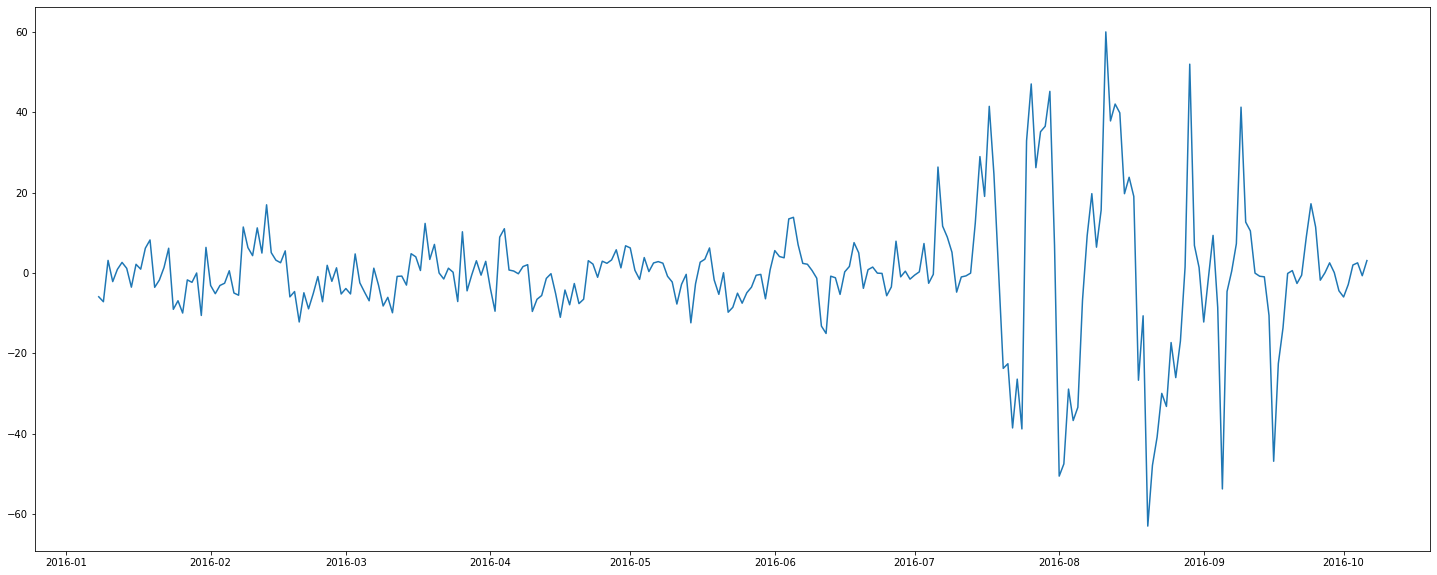

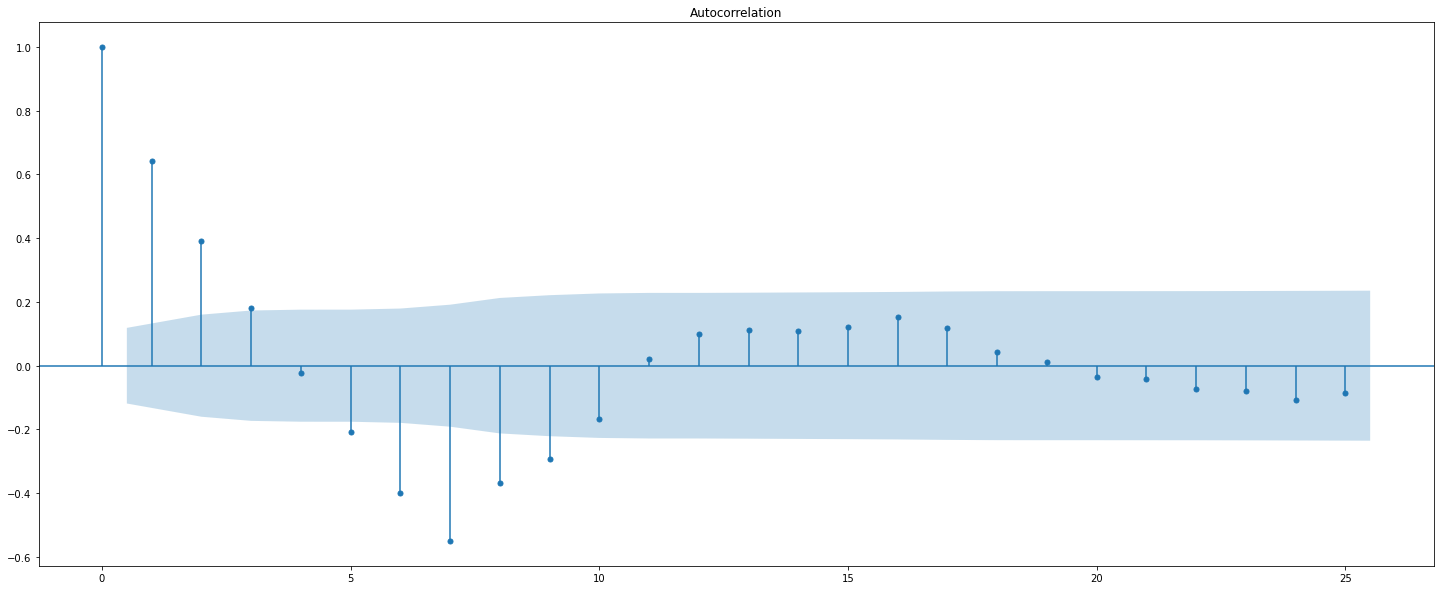

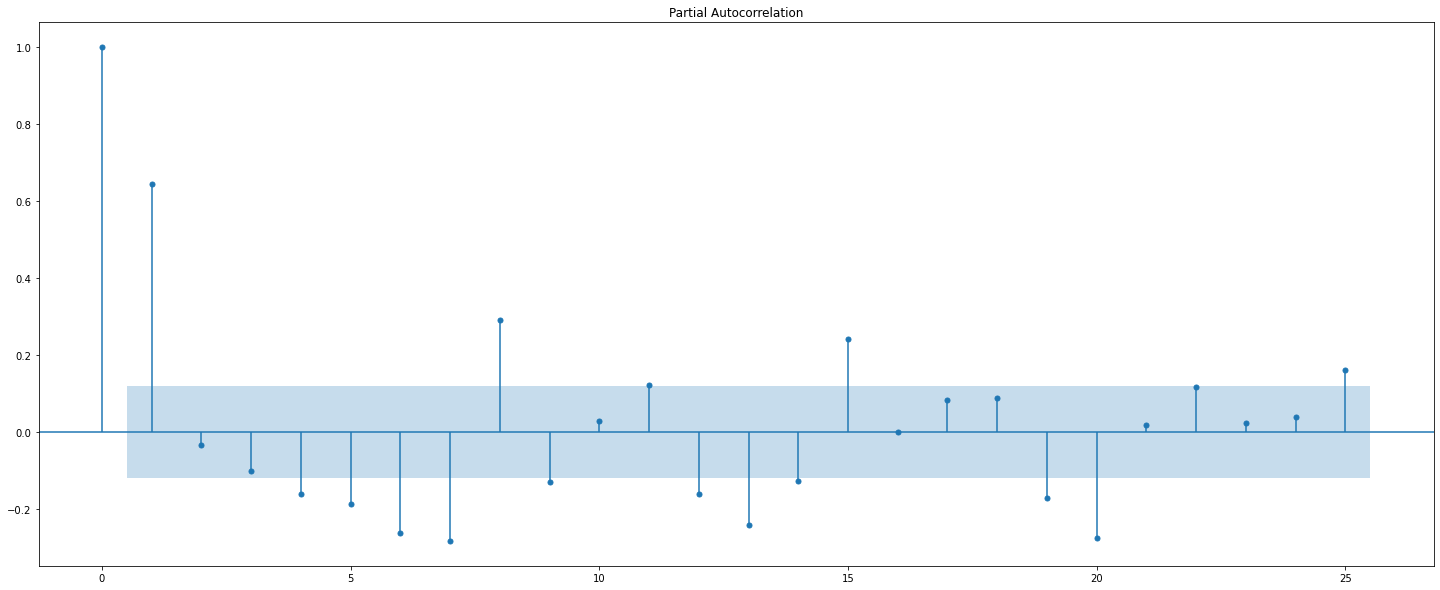

In [219]:
plt.figure(figsize=(25,10))
plt.plot(train_use_diff.dropna())
plot_acf(train_use_diff.dropna());
plot_pacf(train_use_diff.dropna());

# Start ARIMA model

In [239]:
# use arima model 
arima_use = ARIMA(train_use_diff.dropna(), order=(1, 0, 0)).fit()
arima_use.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  273
Model:                     ARMA(1, 0)   Log Likelihood               -1064.275
Method:                       css-mle   S.D. of innovations             11.924
Date:                Sun, 04 Apr 2021   AIC                           2134.550
Time:                        12:06:28   BIC                           2145.378
Sample:                    01-08-2016   HQIC                          2138.896
                         - 10-06-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2530      1.988     -0.127      0.899      -4.150       3.644
ar.L1.y        0.6394      0.046     13.827      0.000       0.549       0.730
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5640           +0.0000j            1.5640            0.0000
-----------------------------------------------------------------------------
"""

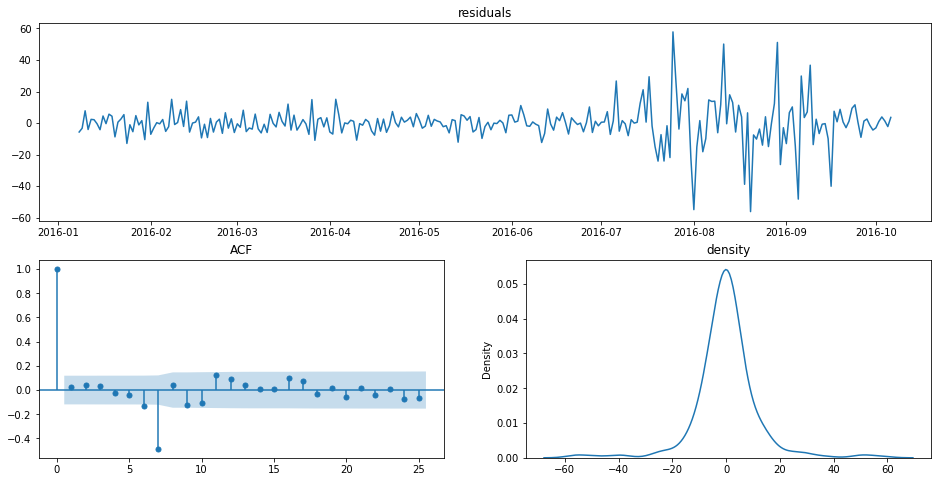

In [240]:
# check residual

def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
residuals_use = pd.Series(arima_use.resid)
check_residuals(residuals_use)

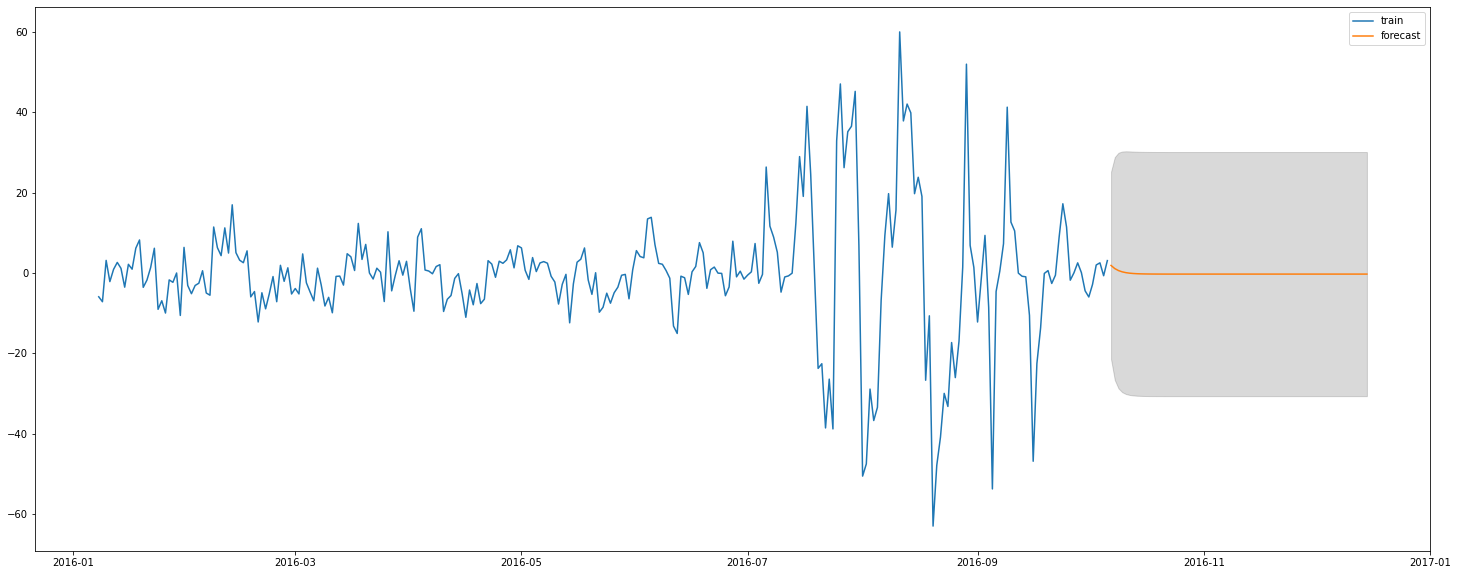

In [241]:
arima_use_forecast, se, conf = arima_use.forecast(len(day_use_ts)-use_split_ratio)

arima_use_forecast = pd.Series(arima_use_forecast, index=test_use.index)
lower_use_series = pd.Series(conf[:, 0], index=test_use.index)
upper_use_series = pd.Series(conf[:, 1], index=test_use.index)

plt.plot(train_use_diff, label='train')
plt.plot(arima_use_forecast, label='forecast')

plt.fill_between(lower_use_series.index, lower_use_series, upper_use_series, color='k', alpha=.15)
plt.legend()

In [242]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [243]:
# inverse differenced series back to original series
use_forecast_series = inverse_differencing_forecast(train_use, train_use_diff, arima_use_forecast, 7)
use_lower_series = inverse_differencing_forecast(train_use,  train_use_diff, lower_use_series, 7)
use_upper_series = inverse_differencing_forecast(train_use,  train_use_diff, upper_use_series, 7)

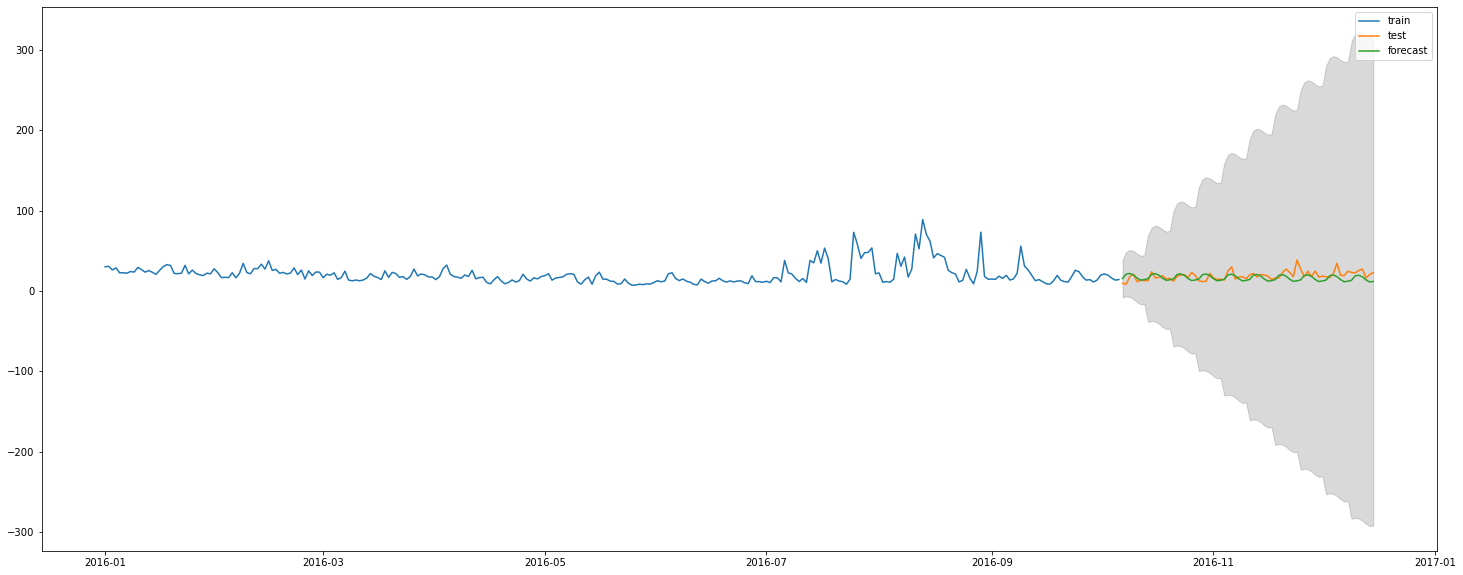

In [244]:
train_test_forecast_plot(train_use, test_use, use_forecast_series, [use_lower_series, use_upper_series])

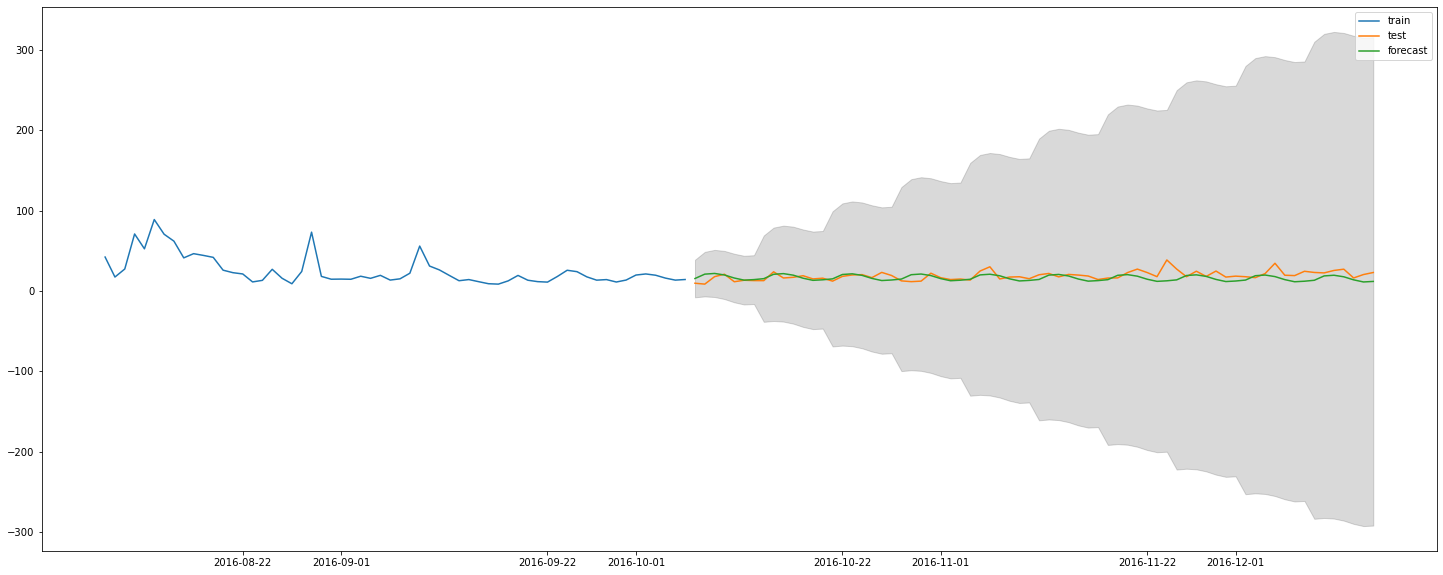

In [245]:
# take a closer look
train_test_forecast_plot(train_use[-60:], test_use, use_forecast_series, [use_lower_series, use_upper_series])

In [246]:
mse = mean_squared_error(test_use, use_forecast_series)
rmse = math.sqrt(mse)
print('Test MSE: ', mse)
print("Test RMSE: ", rmse)

Test MSE:  44.98026001215677
Test RMSE:  6.706732439284929


# GRID SEARCH BEST MODEL

# Sarima

In [247]:
train_use_diff = train_use.diff(periods = 7)
print_adf_result(adfuller(train_use_diff.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.968011
P-Value                   0.000026
# Lags Used              14.000000
# Observations Used     258.000000
Critical Value (1%)      -3.455953
Critical Value (5%)      -2.872809
Critical Value (10%)     -2.572775
dtype: float64


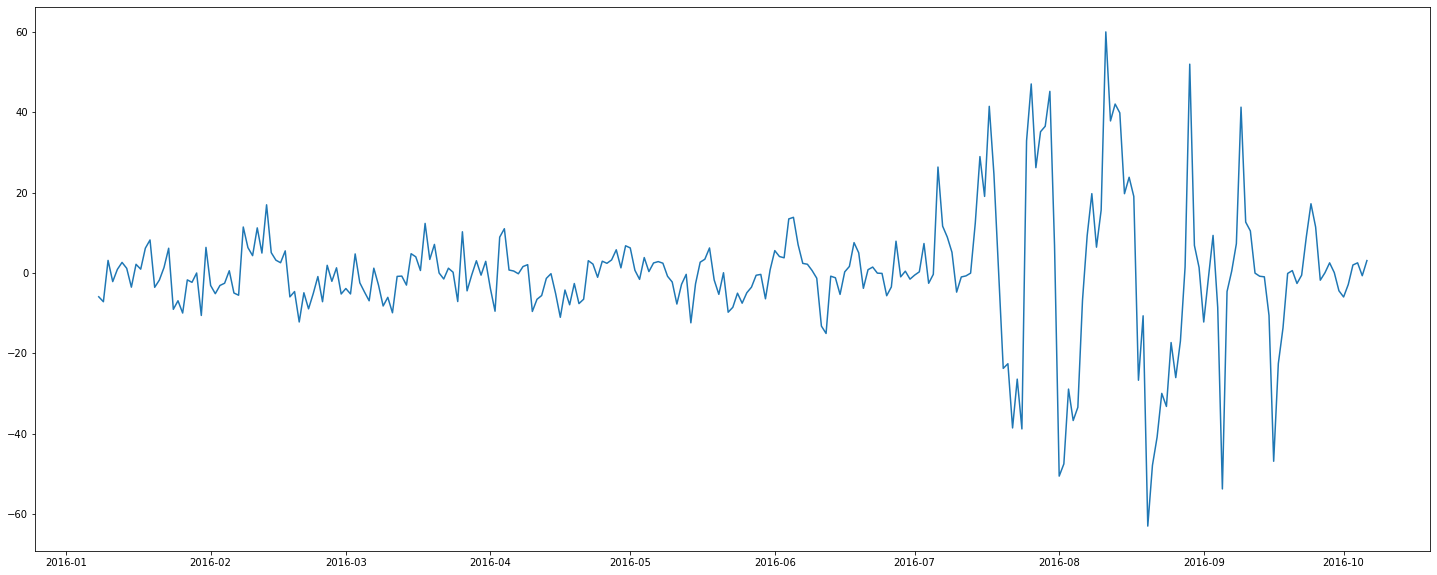

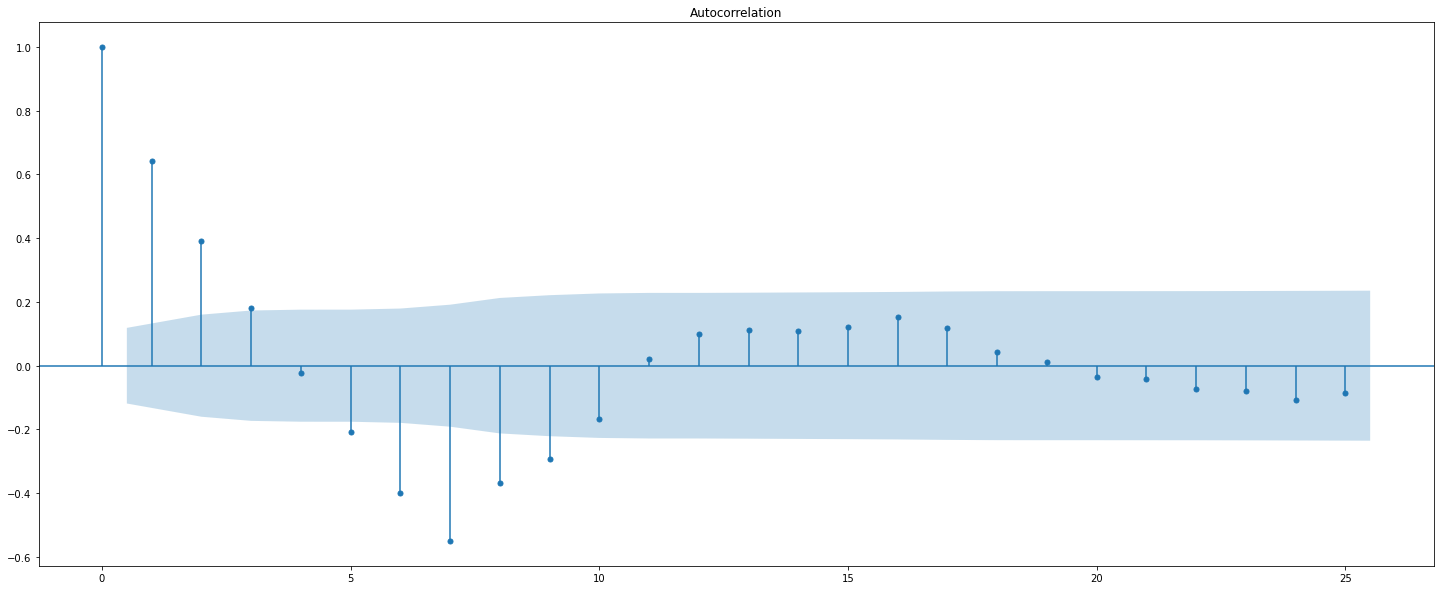

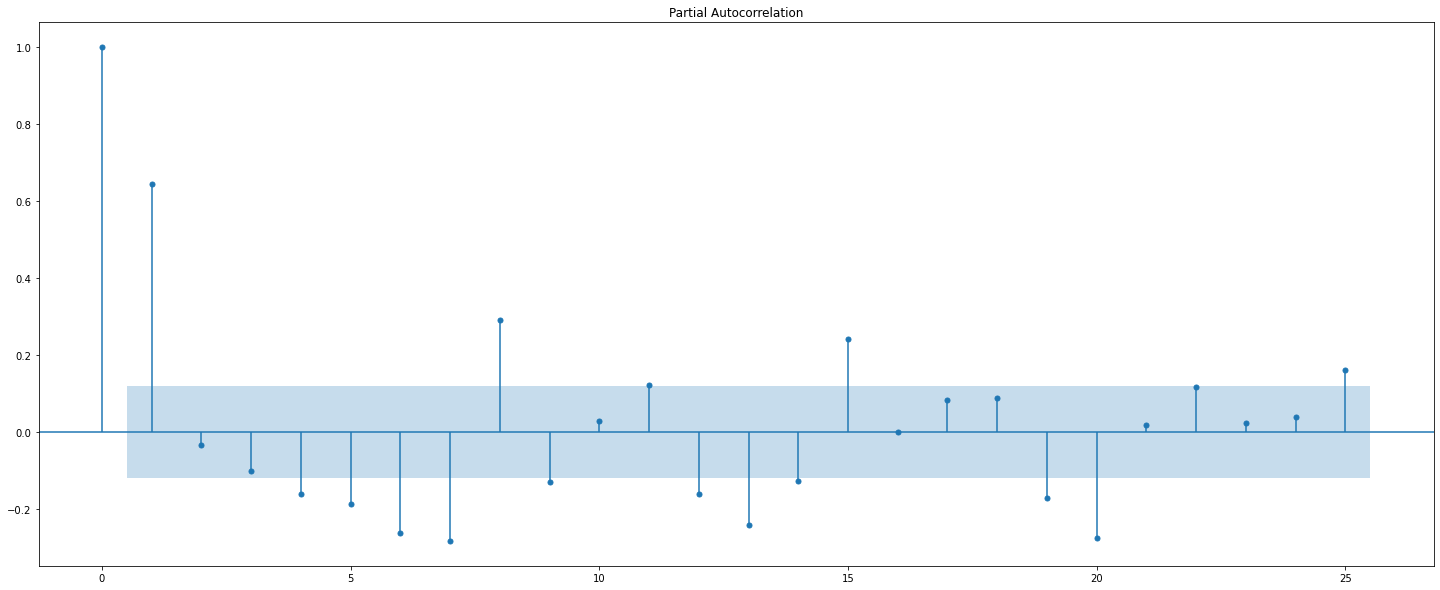

In [248]:
plt.figure(figsize=(25,10))
plt.plot(train_use_diff.dropna())
plot_acf(train_use_diff.dropna());
plot_pacf(train_use_diff.dropna());

In [254]:
sarimax = SARIMAX(train_use_diff, order=(1,0,0), seasonal_order=(1,1,0,7)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  280
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -1027.836
Date:                           Sun, 04 Apr 2021   AIC                           2061.672
Time:                                   12:10:17   BIC                           2072.577
Sample:                               01-01-2016   HQIC                          2066.046
                                    - 10-06-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6004      0.036     16.838      0.000       0.530       0.670
ar.S.L7       -0.4805      0.028    -16.992      0.000      -0.536      -0.425
sigma2       108.1785      4.538     23.839      0.000      99.285     117.072
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               691.27
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              10.58   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

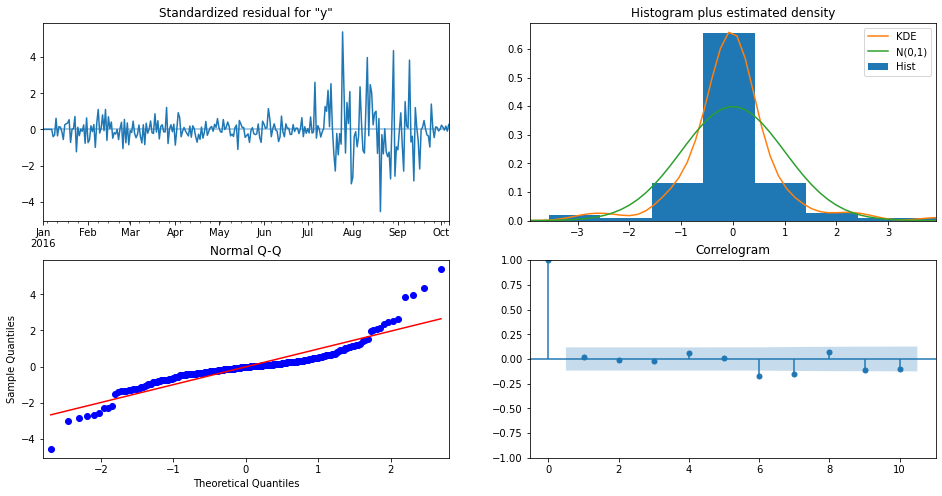

In [255]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [256]:
sarimax_forecast = sarimax.get_forecast(len(day_use_ts)-use_split_ratio)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

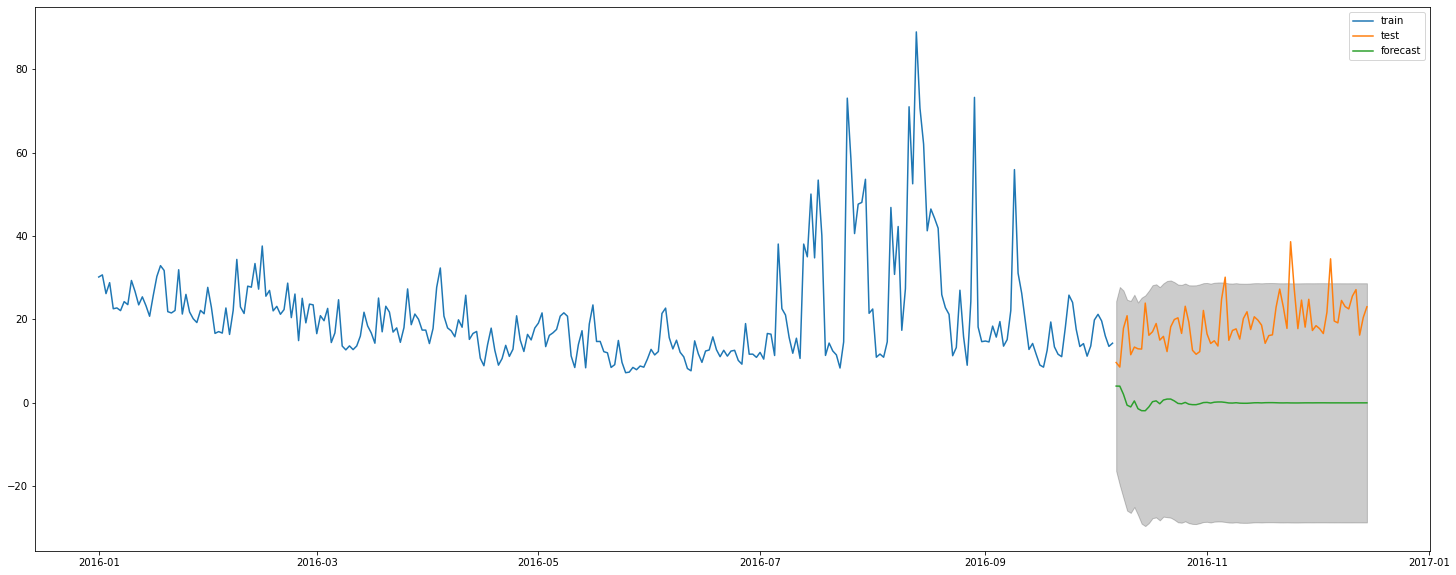

In [257]:
plt.plot(train_use, label='train')
plt.plot(test_use, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()


In [253]:
mse = mean_squared_error(test_use, use_forecast_series)
rmse = math.sqrt(mse)
print('Test MSE: ', mse)
print("Test RMSE: ", rmse)

Test MSE:  44.98026001215677
Test RMSE:  6.706732439284929
